# WRG: Weapon Recoil Generation

## 1. 좌표 값 생성 함수 설계

In [79]:
import numpy as np

class WeaponRecoilGeneration():
    """
    무기 유형별(기관총, 권총, 산탄총) 반동 궤적 데이터를 생성하는 클래스 입니다

    Attributes:
        shots (int, optional): 총 발사 횟수. 개별 메서드에서 인자로 별도 지정 가능

    Methods:
        machinegun_recoil_points(shots: int):
            기관총 반동 궤적을 생성합니다. 
            반동이 강하고 연속적인 사격 패턴을 모사합니다.
        
        pistol_recoil_points(shots: int):
            권총 반동 궤적을 생성합니다. 
            상대적으로 짧고 일관된 반동 패턴을 가집니다.

        shotgun_recoil_points(shots: int):
            산탄총 반동 궤적을 생성합니다.
            퍼짐이 강한 산포형 탄착군을 모사합니다.
    """

    def __init__(self, shots=None):
        self.shots = shots

    def machinegun_recoil_points(self, shots: int):
        x = []
        y = []

        for i in range(1, shots + 1):
            # 초탄
            if i <= int(shots/3):
                dx = np.random.uniform(0.0, 0.2)        # X축 흔들림 거의 없음
                dy = np.random.uniform(0.0, 0.65)       # Y축 미세 흔들림 증가
            # 중탄
            elif i <= int((shots/3)*2):
                dx = np.random.normal(0.1, 0.3)         # X축 미세 흔들림 증가
                dy = np.random.normal(0.1, 0.3)         # Y축 미세 흔들림 증가
            # 후탄
            else:
                dx = np.random.uniform(-1, 0.5)         # X축 흔들림 강함
                dy = np.random.normal(0.0 , 0.2)        # Y축 흔들림 거의 없음

            x.append(dx)
            y.append(dy)

        # x의 요소를 누적합으로 계산
        x_cum = np.cumsum(x)
        y_cum = np.cumsum(y)
        print("생성이 완료되었습니다")
        
        return x_cum, y_cum

    def pistol_recoil_points(self, shots: int):
        x = []
        y = []

        for i in range(1, shots + 1):
            # 초탄
            if i <= int(shots/3):
                dx = np.random.uniform(0.0, 0.2)        # 약간의 X축 흔들림 부여
                dy = np.random.uniform(0.0, 0.5)        # 세로 반동 (조금 줄임)
            # 중탄
            elif i <= int((shots/3)*2):
                dx = np.random.uniform(0.3, 0.3)        # X축 미세 흔들림 증가
                dy = np.random.uniform(0.3, 0.3)
            # 후탄
            else:
                dx = np.random.uniform(-0.1, 0.3)       # X축 흔들림 강함
                dy = np.random.uniform(-0.1, 0.2)         # Y축 거의 없음

            x.append(dx)
            y.append(dy)

        # x의 요소를 누적합으로 계산
        x_cum = np.cumsum(x)
        y_cum = np.cumsum(y)
        print("생성이 완료되었습니다")

        return x_cum, y_cum
    
    def shotgun_recoil_points(self, shots: int):
        x = []
        y = []

        pellets_per_shot = 16  # 한 발에 퍼지는 산탄 수

        for i in range(1, shots + 1):
            for _ in range(pellets_per_shot):
                if i == 1:
                    dx = np.random.normal(0.0, 0.5)
                    dy = np.random.normal(0.0, 0.5)
                else:
                    dx = np.random.normal(0.0, 2.5)
                    dy = np.random.normal(0.0, 2.5)

                x.append(dx)
                y.append(dy)

        # 누적합 없이 그대로 분포 시각화
        x_cum = x
        y_cum = y
        print("생성이 완료되었습니다")

        return x_cum, y_cum

## 2. 생성 데이터 시각화 및 데이터프레임화 함수 설계

In [82]:
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt

class RecoilVisualizer():
    """
    총기 반동 궤적 데이터(x, y)를 시각화하고, Pandas DataFrame 형태로 변환하는 기능을 제공하는 클래스입니다.

    Attributes:
        x (list or np.ndarray): X축 좌표값 (수평 반동)
        y (list or np.ndarray): Y축 좌표값 (수직 반동)

    Methods:
        plot_recoil_pattern(x, y):
            주어진 x, y 좌표값을 기반으로 총기 반동 궤적을 시각화합니다.

        dataset(x, y):
            주어진 x, y 좌표값을 Pandas DataFrame으로 변환하여 반환합니다.
    """

    def __init__(self, data=None):
        self.data = data
        
    def plot_recoil_pattern(self, data):
        """생성된 좌표값을 시각화하는 메서드"""
        plt.figure(figsize=(5, 5))
        plt.scatter(data[0], data[1], c='red', s=10, marker='s')  # y축 반전해서 위로 튀는 느낌
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
        plt.axvline(0, color='black', linestyle='--', linewidth=1)
        plt.gca().set_facecolor('white')
        plt.grid(True, linestyle=':', color='grey', alpha=0.3)
        plt.xticks(np.arange(-10, 10, 1))
        plt.yticks(np.arange(-10, 10, 1))
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.gca().set_aspect('equal')
        plt.title("Improved Recoil Pattern", color='black')
        plt.tick_params(colors='black')
        plt.tight_layout()
        
        return plt.show()
    
    def dataset(self, data):
        """생성된 좌표값을 데이터프레임화하는 메서드"""
        df = pd.DataFrame({"x": data[0], "y": data[1]})
        
        return df

## 3. 사용 예시

### 1) 좌표 생성 함수

In [94]:
wrg = WeaponRecoilGeneration()
a = wrg.machinegun_recoil_points(30)
b = wrg.pistol_recoil_points(12)
c = wrg.shotgun_recoil_points(4)

생성이 완료되었습니다
생성이 완료되었습니다
생성이 완료되었습니다


### 2) 생성된 좌표 시각화

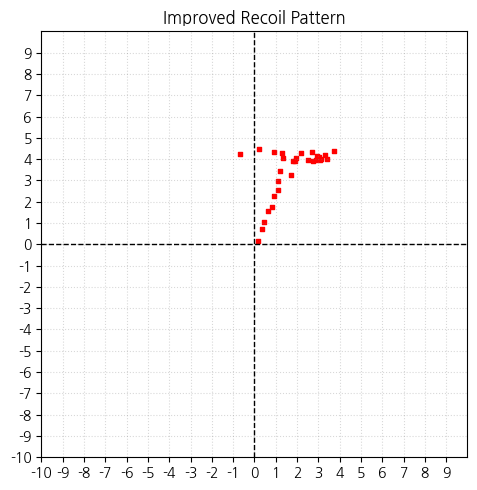

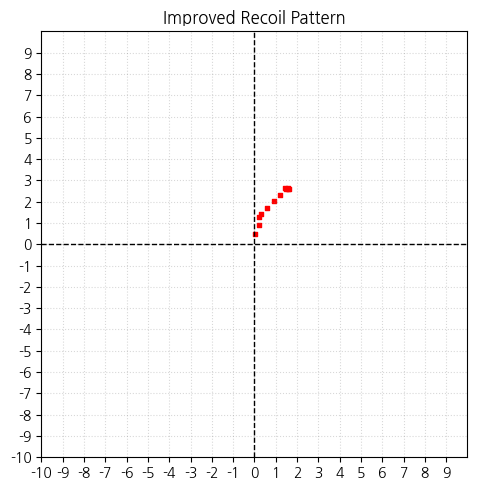

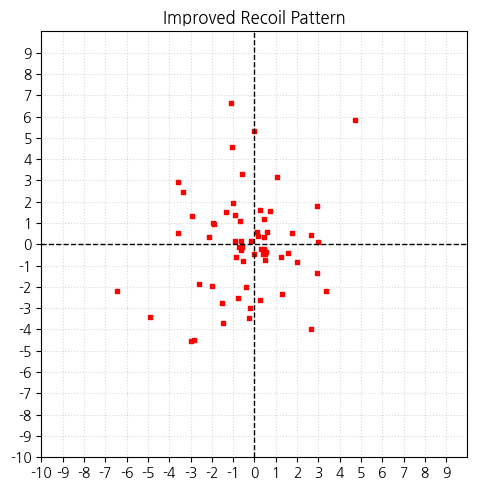

In [95]:
rvz = RecoilVisualizer()
rvz.plot_recoil_pattern(a)
rvz.plot_recoil_pattern(b)
rvz.plot_recoil_pattern(c)

### 3) 생성된 좌표 데이터프레임화

In [75]:
rvz.dataset(a)
rvz.dataset(b)
rvz.dataset(c)

,x,y
0,0.264726,-0.340562
1,-2.503790,-1.281659
2,-0.379643,-2.280442
3,-2.326666,-3.800210


## 4. MCP Tool 만들기